In [1]:
import os, astropy
import numpy as np
import lightkurve as lk
import pbjam as pb
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.units import Quantity, Unit
from astroquery.vizier import Vizier
from scipy.signal import find_peaks

%matplotlib inline

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
print(f'Lightkurve version {lk.__version__}')
print(f'PBjam version {pb.__version__}')

Lightkurve version 2.4.0
PBjam version 1.0.1


In [176]:
v = Vizier(row_limit=-1)
tables = v.query_constraints("J/MNRAS/446/2959/tables12")
obs = tables[0].to_pandas()
obs = obs.loc[obs["_16Cyg"]=="A"]
obs.head()

,_16Cyg,n,l,Freq,Region
0,A,12,2,1488.239990,0.51
1,A,13,0,1495.000000,0.07
2,A,13,1,1541.920044,0.07
3,A,13,2,1591.290039,0.19
4,A,14,0,1598.689941,0.07


Data downloaded from KASOC.

In [3]:
path = os.path.expanduser("~/OneDrive/Data/alexlyttle/thesis/16cyga")

In [4]:
data = pd.read_table(
    os.path.join(path, "kplr012069424_kasoc-wpsd_slc_v1.pow"),
    names=["freq", "psd"],
    delimiter="\s+",
    comment="#",
    na_values="-Inf",
)
data.head()

,freq,psd
0,0.013242,8.280630
1,0.026485,19.702125
2,0.039727,3.589803
3,0.052970,1.597164
4,0.066212,12.517209


In [32]:
nu_max = Quantity(2100.0, unit=freq_unit)
delta_nu = Quantity(103.5, unit=freq_unit)

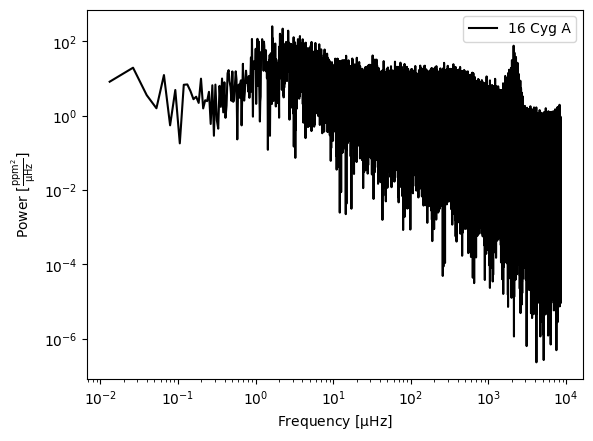

In [345]:
freq_unit = Unit("uHz")
power_unit = Unit("ppm")**2/freq_unit
pg = lk.periodogram.Periodogram(
    Quantity(data.freq, unit=freq_unit),
    Quantity(data.psd, unit=power_unit),
    label="16 Cyg A",
)
ax = pg.plot(style="default", color="k")
ax.set_xscale("log")
ax.set_yscale("log");

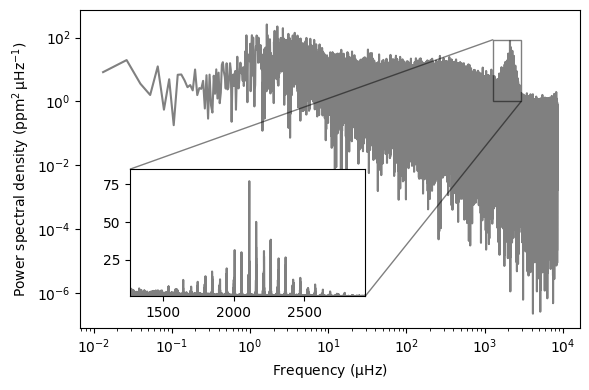

In [357]:
style = "default"
color = "grey"

fig, ax = plt.subplots(figsize=(6, 4))
ax = pg.plot(style=style, color=color, ax=ax, 
             ylabel=f"Power spectral density ({power_unit.to_string('latex_inline')})", 
             xlabel=f"Frequency ({freq_unit.to_string('latex_inline')})")
ax.set_xscale("log")
ax.set_yscale("log")
ax.get_legend().remove()

axins = ax.inset_axes([0.1, 0.1, 0.47, 0.4])
axins = pg.plot(style=style, color=color, ax=axins, xlabel="", ylabel="")
axins.set_xlim((nu_max-8*delta_nu).value, (nu_max+8*delta_nu).value)
axins.set_ylim(1, 85)
axins.get_legend().remove()

ax.indicate_inset_zoom(axins, edgecolor="black")
fig.tight_layout()
fig.savefig("../figures/seismo-psd.pdf", format="pdf", dpi=300)

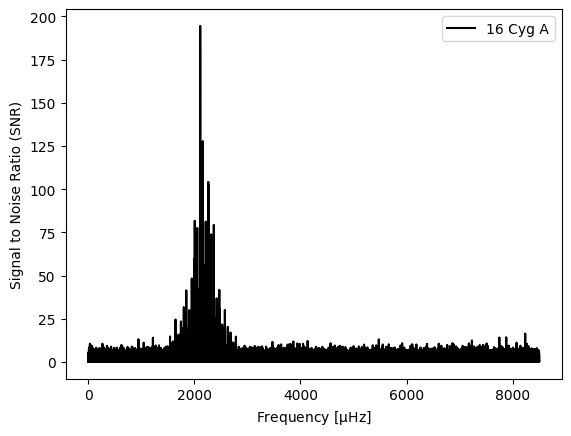

In [27]:
snr = pg.flatten()
snr.plot(style="default", color="k");

Text(0, 0.5, 'Signal-to-noise ratio')

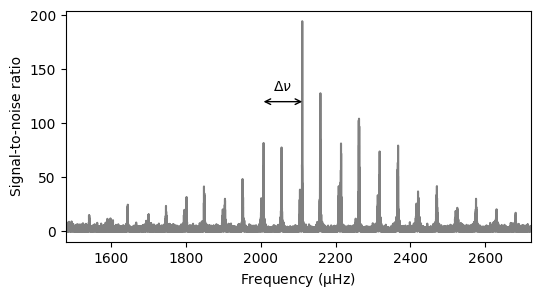

In [354]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(snr.frequency, snr.power, color=color)
ax.set_xlim((nu_max-6*delta_nu).value, (nu_max+6*delta_nu).value)

xy0 = (obs.loc[(obs.l==0) & (obs.n==19), "Freq"], 120)
xy1 =(obs.loc[(obs.l==0) & (obs.n==18), "Freq"], 120)
ax.annotate("", xy0, xy1, arrowprops=dict(arrowstyle='<->', shrinkA=0, shrinkB=0))
ax.text((xy0[0].values+xy1[0].values)/2, 130, r"$\Delta\nu$", horizontalalignment="center")

ax.set_xlabel(f"Frequency ({freq_unit.to_string('latex_inline')})")
ax.set_ylabel(f"Signal-to-noise ratio")

## Echelle Plot

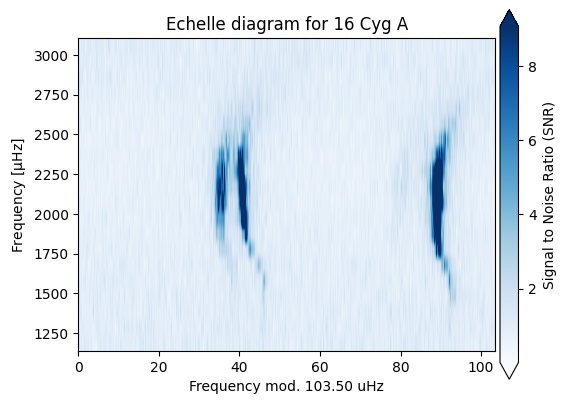

In [33]:
seis = snr.to_seismology()
seis.plot_echelle(delta_nu, nu_max, smooth_filter_width=0.00);

I don't like how the `lightkurve` package plots the Echelle. Plus, it seems to be scaled incorrectly, particularly noticeable at low resolution. (Try setting a maximum frequency and you'll notice the y-axis does not go high enough).

I copied and amended the code from the `lightkurve` `plot_echelle` function below.


In [292]:
fs = snr.frequency[1] - snr.frequency[0]  # frequency spacing

ednu = np.round(delta_nu/fs)*fs  # round delta_nu to nearest frequency spacing

# frequency range to be +/- 10 delta_nu around nu_max
fmin = nu_max - 10*ednu  
fmax = nu_max + 10*ednu

# offset to account for if first freq. is not zero
x0 = int(snr.frequency[0] / fs)

ff = snr.frequency[int(fmin / fs) - x0 : int(fmax / fs) - x0]  # Selected frequency range
pp = snr.power[int(fmin / fs) - x0 : int(fmax / fs) - x0]      # Power range

mod_zeros = find_peaks(-1.0 * (ff % ednu))[0]  # find points where each dnu row starts
start = mod_zeros[0]  # freq. index of first row start
approx_end = mod_zeros[-1]  # freq. index of last row start
n_rows = len(mod_zeros) - 1
n_columns = int((approx_end - start) / n_rows)
end = start + n_columns * n_rows  # freq. index of last row end
ep = np.reshape(pp[start:end], (n_rows, n_columns))
ef = np.reshape(ff[start:end], (n_rows, n_columns))

I also want to annotate the plot to identify l=0,1,2 ridges.

In [392]:
l = np.arange(3)
epsilon = 1.39
ridges = (ednu * (l/2 + epsilon - 0.03*l)) % ednu

Now make plot in style of `lightkurve` with scaling corrections.

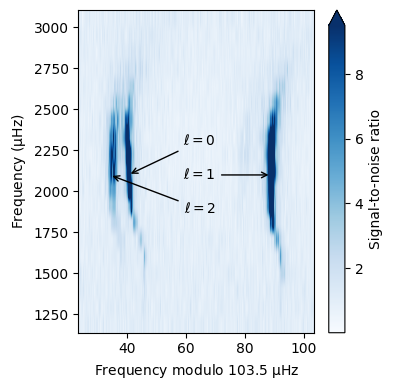

In [393]:
figsize = (4, 4)
fig, ax = plt.subplots( figsize=figsize)

# PLOT ECHELLE DIAGRAM
# Extent of plot from 0 to dnu in x-axis and smallest to largest freq. in y-axis
extent = (0.0, ednu.value, ef[0, 0].value, ef[-1, -1].value)
vmax = np.nanquantile(ep.value, .99)  # set colormap max to 99th percentile of data
cmap = "Blues"

im = ax.imshow(ep.value, cmap=cmap, aspect="auto", extent=extent,
               origin="lower", vmax=vmax)

cbar = fig.colorbar(im, extend="max", ax=ax)
cbar.set_label("Signal-to-noise ratio")

# ANNOTATE 'l' RIDGES
# ax.vlines(ridges.value, fy[0].value, fy[-1].value, color="k", linestyle="--")

arrowprops = dict(arrowstyle="->")
halign = "center"
valign = "center"
ax.annotate(
    r"$\ell=0$", 
    (ridges.value[0], nu_max.value), 
    (((ridges[0]+ridges[1])/2).value, (nu_max+2*ednu).value),
    arrowprops=arrowprops,
    horizontalalignment=halign,
    verticalalignment=valign
)
ax.annotate(
    r"$\ell=1$", 
    (ridges.value[1], nu_max.value),
    (((ridges[0]+ridges[1])/2).value, nu_max.value),
    arrowprops=arrowprops,
    horizontalalignment=halign,
    verticalalignment=valign
)
ax.annotate(
    r"$\ell=2$",
    (ridges.value[2], nu_max.value),
    (((ridges[0]+ridges[1])/2).value, (nu_max-2*ednu).value),
    arrowprops=arrowprops,
    horizontalalignment=halign,
    verticalalignment=valign
)

# PLOT OBSERVED MODES
# for l, marker in enumerate(["o", "^", "s"]):
#     mask = (obs["l"] == l)
#     ax.errorbar(obs.loc[mask, "Freq"]%ednu, obs.loc[mask, "Freq"], 
#                 xerr=obs.loc[mask, "Region"], fmt=marker, markersize=2)

ax.set_xlim(23.5, 103.5)
ax.set_xlabel(f"Frequency modulo {ednu.to_string(precision=5, format='latex_inline')}")
ax.set_ylabel(f"Frequency ({freq_unit.to_string('latex_inline')})")
fig.tight_layout()

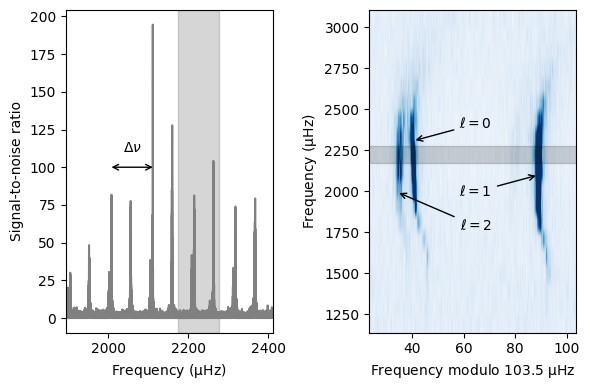

In [400]:
fill_row = 10

fig, axes = plt.subplots(1, 2, figsize=(6, 4))

ax = axes[1]
im = ax.imshow(ep.value, cmap=cmap, aspect="auto", extent=extent,
               origin="lower", vmax=vmax)

# cbar = fig.colorbar(im, extend="max", ax=ax)
# cbar.set_label("Signal-to-noise ratio")

arrowprops = dict(arrowstyle="->")
halign = "center"
valign = "center"
ax.annotate(
    r"$\ell=0$", 
    (ridges.value[0], (nu_max+2*ednu).value), 
    (((ridges[0]+ridges[1])/2).value, (nu_max+3*ednu).value),
    arrowprops=arrowprops,
    horizontalalignment=halign,
    verticalalignment=valign
)
ax.annotate(
    r"$\ell=1$", 
    (ridges.value[1], nu_max.value),
    (((ridges[0]+ridges[1])/2).value, (nu_max-1*ednu).value),
    arrowprops=arrowprops,
    horizontalalignment=halign,
    verticalalignment=valign
)
ax.annotate(
    r"$\ell=2$",
    (ridges.value[2], (nu_max-1*ednu).value),
    (((ridges[0]+ridges[1])/2).value, (nu_max-3*ednu).value),
    arrowprops=arrowprops,
    horizontalalignment=halign,
    verticalalignment=valign
)

ax.axhspan(ef[fill_row, 0].value, ef[fill_row, -1].value, color="k", alpha=0.16)

ax.set_xlim(23.5, 103.5)
ednu_str = ednu.to_string(precision=5, format='latex_inline')
ax.set_xlabel(f"Frequency modulo {ednu_str}")
ax.set_ylabel(f"Frequency ({freq_unit.to_string('latex_inline')})")

ax = axes[0]
ax.plot(snr.frequency, snr.power, color=color)
ax.set_xlim((nu_max-2*delta_nu).value, (nu_max+3*delta_nu).value)

yarrow = 100
xy0 = (obs.loc[(obs.l==0) & (obs.n==19), "Freq"], yarrow)
xy1 =(obs.loc[(obs.l==0) & (obs.n==18), "Freq"], yarrow)
ax.annotate("", xy0, xy1, arrowprops=dict(arrowstyle='<->', shrinkA=0, shrinkB=0))

text = r"$\Delta\nu$"
ytext = 110
ax.text((xy0[0].values+xy1[0].values)/2, ytext, text, horizontalalignment="center")

ax.axvspan(ef[fill_row, 0].value, ef[fill_row, -1].value, color="k", alpha=0.16)

ax.set_xlabel(f"Frequency ({freq_unit.to_string('latex_inline')})")
ax.set_ylabel(f"Signal-to-noise ratio")

fig.tight_layout()
fig.savefig("../figures/seismo-echelle.pdf", format="pdf", dpi=300)

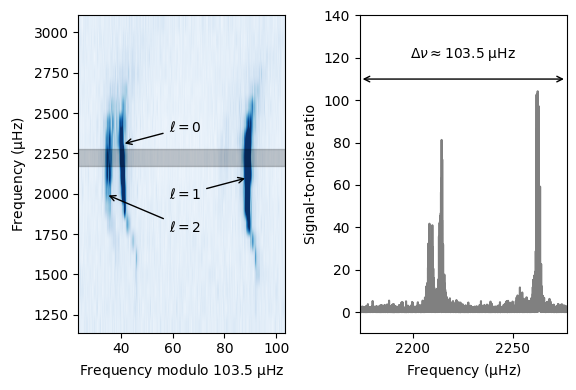

In [411]:
fill_row = 10

fig, axes = plt.subplots(1, 2, figsize=(6, 4))

ax = axes[0]
im = ax.imshow(ep.value, cmap=cmap, aspect="auto", extent=extent,
               origin="lower", vmax=vmax)

# cbar = fig.colorbar(im, extend="max", ax=ax)
# cbar.set_label("Signal-to-noise ratio")

arrowprops = dict(arrowstyle="->")
halign = "center"
valign = "center"
ax.annotate(
    r"$\ell=0$", 
    (ridges.value[0], (nu_max+2*ednu).value), 
    (((ridges[0]+ridges[1])/2).value, (nu_max+3*ednu).value),
    arrowprops=arrowprops,
    horizontalalignment=halign,
    verticalalignment=valign
)
ax.annotate(
    r"$\ell=1$", 
    (ridges.value[1], nu_max.value),
    (((ridges[0]+ridges[1])/2).value, (nu_max-1*ednu).value),
    arrowprops=arrowprops,
    horizontalalignment=halign,
    verticalalignment=valign
)
ax.annotate(
    r"$\ell=2$",
    (ridges.value[2], (nu_max-1*ednu).value),
    (((ridges[0]+ridges[1])/2).value, (nu_max-3*ednu).value),
    arrowprops=arrowprops,
    horizontalalignment=halign,
    verticalalignment=valign
)

span = (ef[fill_row, 0].value, ef[fill_row, -1].value)
ax.axhspan(*span, color="k", alpha=0.2)

ax.set_xlim(23.5, 103.5)
ednu_str = ednu.to_string(precision=5, format='latex_inline')
ax.set_xlabel(f"Frequency modulo {ednu_str}")
ax.set_ylabel(f"Frequency ({freq_unit.to_string('latex_inline')})")

ax = axes[1]
ax.plot(snr.frequency, snr.power, color=color)
ax.set_xlim(span)
ax.set_ylim(top=140)
yarrow = 110
xy0 = (span[0], yarrow)
xy1 = (span[1], yarrow)
ax.annotate("", xy0, xy1, arrowprops=dict(arrowstyle='<->'))

text = r"$\Delta\nu\approx$" + ednu_str
ytext = 120
ax.text((xy0[0]+xy1[0])/2, ytext, text, horizontalalignment="center")

# ax.axvspan(ef[fill_row, 0].value, ef[fill_row, -1].value, color="k", alpha=0.16)

ax.set_xlabel(f"Frequency ({freq_unit.to_string('latex_inline')})")
ax.set_ylabel(f"Signal-to-noise ratio")

fig.tight_layout()